# Anatomy of an Integration Time Calculation

This sheet walks through the basics of exposure time calculations and describes each of the required inputs.


If running via Google Colab, you must first execute the contents of notebook `00_Google_Colab_Setup.ipynb` (only if you have never done so previously). Then execute all cells tagged with &#128992;.  If running via a local installation, you should skip all of the colab-specific (&#128992;) cells.

## 🟠 Setup for Google Colab Use

### 🟠 Run the next cell to mount the Google Drive

You will receive some or all of the following prompts:

* Warning: This notebook was not authored by Google - Click "Run Anyway" 
* Permit this notebook to access your Google Drive files? - Click "Connect to Google Drive"
* A new browser window will prompt you to select an account and authorize access
  * Select the Google account you wish to use and click Continue on each subsequent screen until the dialog vanishes

Upon completion of cell execution, you should see `Mounted at /content/drive`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 🟠 Run the next cell to change to the corgietc directory and install the required software

This process should take less than a minute, but, depending on bandwidth availability, may take as long as a few minutes. You will see a variety of messages about package downloads.  Upon completion of cell execution, you should see `Sucessfully installed` followed by a list of installed packages and their versions.

You may see the prompt "Restart session".  You do not need to do this - click 'Cancel'.

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
import os

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# directory path
corgietc_dir = 'corgietc'
corgietc_path = os.path.join(drive_dir, corgietc_dir)
cgi_noise_repo_path = os.path.join(corgietc_path, "cgi_noise")
corgietc_repo_path = os.path.join(corgietc_path, "corgietc")
corgietc_notebooks_path = os.path.join(corgietc_repo_path, "Notebooks")

# Change to the cgi_noise repo path and update the repo
os.chdir(cgi_noise_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Change to the corgietc repo path and update the repo
os.chdir(corgietc_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Refresh package list to pick up new installations
import site
site.main()

# Change to the Notebooks directory
os.chdir(corgietc_notebooks_path)

### 🟠 Import jupyter widget for Colab

In [ ]:
# need to import third party jupyter widget
from google.colab import output
output.enable_custom_widget_manager()

## All Cells from this point should be run for both Colab and local installations

In [1]:
# import all required packages
import corgietc
import os
import json
import EXOSIMS.Prototypes.TargetList
import EXOSIMS.Prototypes.TimeKeeping
import copy
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

## Introduction

The Roman Coronagraph Exposure Time Calculator (ETC; ``corgietc``) is implemented by integrating two Python packages: ``cgi_noise`` and ``EXOSIMS``.  ``cgi_noise`` provides detailed modeling of the Roman Coronagraph and the definitions of the Roman Coronagraph observing modes (scenarios), along with basic models for astrophysical inputs.  ``EXOSIMS`` is a mission modeling framework, and provides its own ETCs, along with detailed astrophysical models and other useful utilities.  ``corgietc`` links these two packages together by implementing an ``EXOSIMS`` ``OpticalSystem`` implementation that calls ``cgi_noise`` for various calculations. This allows us to use the ``cgi_noise`` instrument model with the various inputs that can be computed by ``EXOSIMS``.

## Required Inputs for Computing Integration Time

Point-source integration time calculations are provided by the `calc_intTime` method of an `EXOSIMS` `OpticalSystem` module (such as ``corgietc``).  This method takes 7 required inputs and one optional one:

1. An `EXOSIMS` `TargetList` object: this includes all information about the targets (stars) that you might want to observe, along with utilities for computing stellar photometry.  Details on the `TargetList` class are available here: https://exosims.readthedocs.io/en/latest/targetlist.html and details on the stellar photometric modeling are available here: https://exosims.readthedocs.io/en/latest/concepts.html#photometry
2. The specific subset of targets you wish to compute integration times for (`sInds`).  `TargetList` stores all stellar information in equally-sized arrays, so this input is an array (or list, or other iterable) of which target indices you wish to select.  If your `TargetList` only contains one target, this input would be 0.
3. The surface brightness of local zodiacal light to assume for the calculation (`fZ`).  This must be an `astropy` `Quantity` object (https://docs.astropy.org/en/stable/units/index.html) whose contents are an array of either size 1 (in which case the same value is used for all calculations) or of an equal size to the `sInds` input. The units must be consistent with arcsec$^{-2}$. For details on the local zodiacal light model, see: https://exosims.readthedocs.io/en/latest/concepts.html#zodiacal-light
4. The intensity of the exo-zodiacal light to assume for the calculation (`JEZ`).  This must be structured in the same way as the `fZ` input, but with units consistent with photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$. For details on the exo-zodiacal light model, see: https://exosims.readthedocs.io/en/latest/concepts.html#exozodiacal-light
5. The desired $\Delta$magnitude between planet and star you wish to reach (`dMag`).  This must be an iterable of either size 1 (same for all calculations) or of equal size to `sInds`. This value sets the integration depth you wish to achieve.
6. The angular separation at which to perform calculations.  Because coronagraph performance varies as a function of angular separation, we must specify where in the throughput/contrast/etc. curves we wish to take our coronagraph performance values from.  That location is specified by this input, which must be an `astropy` `Quantity` array (with the same dimensionality assumptions as the other inputs) with units compatible with arcseconds. For more information on the parametrization of coronagraph performance, see here: https://exosims.readthedocs.io/en/latest/opticalsystem.html#standardized-coronagraph-parameters. Note that for the Roman coronagraph, we do **not** parametrize by stellar angular diameter - the assumption is that all of our target stars are fully unresolved.
7. The observing mode/scenario (`mode`).  An observing mode is the combination of a specific coronagraph with a specific detector in a specific bandpass.  It also defines the target signal-to-noise ratio (SNR) that you wish to achieve for your observation.  More details here: https://exosims.readthedocs.io/en/latest/opticalsystem.html#optical-system-definition
8. (Optional) An `EXOSIMS` `TimeKeeping` object.  As the name implies, a `TimeKeeping` object tracks elapsed mission time (amongst other time-associated utilities.  Time-on-orbit is an input into the integration time because we have a degradation model for our detector, which attempts to predict performance changes due to radiation exposure over the length of the mission.  If omitted, ``corgietc`` automatically assumes 21 months at L2. Note that the degradation model implemented by ``cgi_noise`` is only valid out to 63 months - past that, we cannot really trust the results.

## Constructing EXOSIMS Objects

All ``EXOSIMS`` objects are constructed via an input specification - a dictionary of key/value pairs, that can be read from a JSON-formatted file stored on disk.  Passing such an input specification to a `TargetList` automatically creates the `TargetList`, along with all other ``EXOSIMS`` modules required by the ``TargetList``, which includes the `OpticalSystem` and `ZodiacalLight` modules (the ones we need for doing our calculations).  More info on `EXOSIMS` objects is available here: https://exosims.readthedocs.io/en/latest/intro.html#framework

`corgietc` provides a default input specification, which we will now load:

In [2]:
# This loads the default input specification
scriptfile = os.path.join(os.environ["CORGIETC_DATA_DIR"], "scripts", "CGI_Noise.json")
with open(scriptfile, "r") as f:
    specs = json.loads(f.read())

The component of the input specification that tells `EXOSIMS` what types of objects to build is called `modules`:

In [3]:
specs["modules"]

{'PlanetPopulation': ' ',
 'StarCatalog': ' ',
 'OpticalSystem': '$CORGIETC_DATA_DIR/../corgietc.py',
 'ZodiacalLight': 'Stark',
 'BackgroundSources': 'GalaxiesFaintStars',
 'PlanetPhysicalModel': 'ForecasterMod',
 'Observatory': ' ',
 'TimeKeeping': ' ',
 'PostProcessing': ' ',
 'Completeness': ' ',
 'TargetList': ' ',
 'SimulatedUniverse': ' ',
 'SurveySimulation': ' ',
 'SurveyEnsemble': ' '}

All entries that are blank spaces indicate that the prototype (default) object type should be built.  As you can see, the template input specification sets the `OpticalSystem` to `corgietc`.  By leaving the `StarCatalog` module blank, we are generating a fake catalog of stars (in fact, just one star). Let's instantiate the `TargetList` and take a look.

In [4]:
# Build the targetlist object
TL = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs))
OS = TL.OpticalSystem

Imported StarCatalog (prototype) from EXOSIMS.Prototypes.StarCatalog
Imported corgietc (named file) from /Users/ds264/Do[...]ietc/corgietc/corgietc.py
Imported Stark (implementation) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported GalaxiesFaintStars (implementation) from EXOSIMS.BackgroundSources.GalaxiesFaintStars
Imported Completeness (prototype) from EXOSIMS.Prototypes.Completeness
Imported PlanetPopulation (prototype) from EXOSIMS.Prototypes.PlanetPopulation
Imported ForecasterMod (implementation) from EXOSIMS.PlanetPhysicalModel.ForecasterMod
1 targets imported from star catalog.
1 targets remain after removing those where spectral class cannot be established.
1 targets remain after removing white dwarfs and subdwarfs
1 targets remain after nan filtering.
1 targets remain after removing zero luminosity targets.
Loaded JEZ0 values from /Users/ds264/.EXOSIMS/cache/TargetList_StarCatalognStars_1_mode_6534987b1b37fa7

/Users/ds264/Documents/gitrepos/EXOSIMS/EXOSIMS/Prototypes/TargetList.py:381: UserWarning: binary_filter is None but filterBinaries is False. Using binary_filter value of None.
  warnings.warn(


Notice that we used a copy of the input specification rather than directly sending it to the `TargetList`.  You can actually do either, but `EXOSIMS` objects will modify the input specification as they pass it around, so if you want to retain the original, you have to use a copy.

We can inspect the single fake target we created:

In [5]:
# let's check on the target
print(f"Name: {TL.Name}")
print(f"is located at {TL.coords}")
print(f"and has a V band magnitude of {TL.Vmag}")

Name: ['Prototype Star 0']
is located at <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(0., 0., 10.)]>
and has a V band magnitude of [5.]


The template specifications have created a 5th magnitude star (in V band) located 10 parsecs away. 

While we're here, we'll also create the optional `TimeKeeping` object, and set the current mission time to 21 months (matching the default):

In [6]:
# create a Timekeeping object and advance the mission time a bit
TK = EXOSIMS.Prototypes.TimeKeeping.TimeKeeping(missionLife = 5.25)   # 63 months in years is 5.25, 21 months is 1.75
TK.allocate_time(21*30.4375*u.d);

OBendTimes is: [1917.5625] d


## Generating Integration Time Calculation Inputs

We will now generate input values for each of the `calc_intTime` inputs.  

### 1. `TargetList`
We already have our `TargetList` object, so this is done.

### 2. `sInds` 
The target listincludes only one target, so:

In [7]:
sInds = 0

### 3. `fZ`
For the local zodiacal light, the `TargetList` provides an attribute with a default value (equivalent to a local zodi brightness of 23 mag arcsec$^{-2}$:

In [8]:
fZ = np.repeat(TL.ZodiacalLight.fZ0, 1)
fZ

<Quantity [6.30957344e-10] 1 / arcsec2>

Note the use of the `numpy` `repeat` method to make this an iterable (as required).

### 7. `mode` 

We're going to go a bit out of order and specify our observing mode next, as it is required for some of the other things we need to compute. All observing modes are stored in `OpticalSystem` attribute `observingModes`.  For `corgietc`, all modes have a `Scenario` keyword, and we can print these out:

In [9]:
for mode in OS.observingModes:
    print(mode["Scenario"])

OPT_IMG_NFB1_HLC


We will pick the first mode from the list - optimistic HLC with imaging in Band 1:

In [10]:
mode = OS.observingModes[0]

### 4. `JEZ`
Similarly, the `TargetList` pre-computes the exozodi of all targets for all observing modes at 1 AU separation.  We can then scale these to the actual planet location desired.  In this case, let's assume a planet at 4.1536 AU (to match a default used for testing in ``cgi_noise``):

In [11]:
JEZ = TL.JEZ0[mode["hex"]]/(4.1536**2)
JEZ

<Quantity [0.46751075] ph / (s arcsec2 m2)>

There was a lot going on in that last call - basically, `TL.JEZ0` is a dictionary of values linked to each mode, indexed by a unique string describing that mode, that is stored in the mode's dictionary under key `hex`.  So, we pulled the value associated with the our selected observing mode, and then scaled it by the distance to the planet (in AU) squared. One important caveat, the exozodi is scaled not only by the planet's location, but by the assumed inclination of the exo-zodiacal disk (i.e., the exosystem's inclination).  By our default input specification, we have assumed that the system is edge-on, which is the worst-case for the exozodi contribution.

### 5. `dMag`
We will just set this to an arbitrary value for now (again selected to match ``cgi_noise`` test defaults.

In [12]:
dMag = np.array([17.5])

### 6. `WA`

We wish to use 7.5 $\lambda/D$ as the coronagraph operating point (again matching ``cgi_noise`` test defaults). The input needs to have physical angle values, so we will scale it by the mode's wavelength and the Roman primary diameter:

In [13]:
WA = np.array([7.5]) * (mode["lam"]/OS.pupilDiam).to(u.arcsec, equivalencies=u.dimensionless_angles())
WA

<Quantity [0.37643545] arcsec>

Note the use of the `astropy` equivalencies to make sure that we are properly treating $\lambda/D$ as an angle.

## Running the integration time calculation

We have all the inputs set up, so now it's just a matter of calling the method:

In [14]:
intTimes = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode, TK=TK)
intTimes.to(u.s)

<Quantity [128.36801183] s>

Finally, let's try this for a range of integration depths.  We will set up a range of $\Delta$mag values (and then repeating the `sInd` such that we compute an intergration time for each one).

In [15]:
# now let's try a range of delta-mags
dMags = np.linspace(16, 23, 100)
intTimes = OS.calc_intTime(TL, [sInds]*len(dMags), fZ, JEZ, dMags, WA, mode, TK=TK)

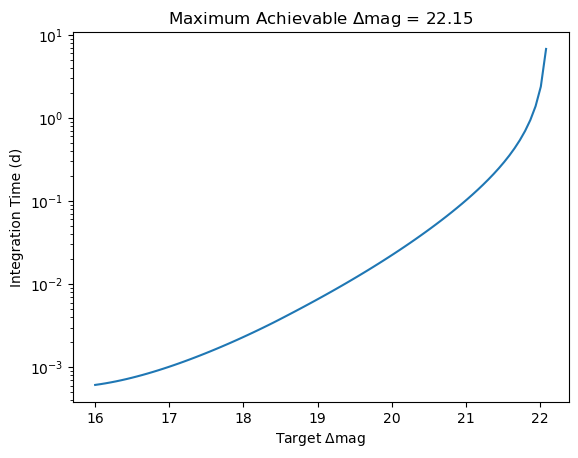

In [16]:
plt.figure()
plt.semilogy(dMags, intTimes)
plt.xlabel(r"Target $\Delta$mag")
plt.ylabel(f"Integration Time ({intTimes.unit})")
plt.title(fr"Maximum Achievable $\Delta$mag = {np.min(dMags[np.isnan(intTimes)]) :.2f}");

Note that plot does not seem to actually reach the maximum $\Delta$mag value that we specified.  This is because that value is infeasible for this particular observation.  When this happens, `calc_intTime` returns a NaN value - for this particular observing scenario, target, and zodi levels, that occurs at a $\Delta$mag of ~22.15, or a flux ratio of:

In [17]:
10**(-0.4*np.min(dMags[np.isnan(intTimes)]))

1.3784592733987659e-09